In [1]:
import aif360
import holisticai
import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from holisticai.bias.mitigation import Reweighing
from holisticai.bias.mitigation import LearningFairRepresentation

In [32]:
# sklearn imports
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

# holisticai imports
from holisticai.bias.metrics import classification_bias_metrics

#import visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# baseline_preprocessed_df = pd.read_csv("C:/Users/athar/OneDrive/Desktop/Rutgers/Ethical Stat Learning/Project/data/data_preprocessed_baseline.csv",index_col=0)
# baseline_preprocessed_df = baseline_preprocessed_df.drop(['id','age_cat'],axis=1)

In [4]:
baseline_preprocessed_df = pd.read_csv("../../data/data_baseline.csv",index_col=0)
baseline_preprocessed_df.head()

,sex,age,juv_fel_count,juv_misd_count,juv_other_count,priors_count,c_charge_desc,two_year_recid,time_in_custody_in_days,time_in_jail_in_days,African-American_race,Asian_race,Hispanic_race,Native American_race,Other_race,Felony_c_charge_degree,High_score_text,Low_score_text,High_v_score_text
id,,,,,,,,,,,,,,,,,,,
1,1,69,0,0,0,0,0.282331,0,7.0,0.0,0,0,0,0,1,1,0,1,0
3,1,34,0,0,0,0,0.568689,1,10.0,10.0,1,0,0,0,0,1,0,1,0
4,1,24,0,0,1,4,0.600344,1,0.0,1.0,1,0,0,0,0,1,0,1,0
5,1,23,0,1,0,1,0.368006,0,0.0,0.0,1,0,0,0,0,1,1,0,0
6,1,43,0,0,0,2,0.439192,0,0.0,0.0,0,0,0,0,1,1,0,1,0


In [5]:
baseline_preprocessed_df = baseline_preprocessed_df.drop(['Asian_race','Hispanic_race','Other_race','High_score_text','High_v_score_text','Low_score_text','Native American_race'],axis=1)

In [6]:
protected_variables = ["sex", "African-American_race"]
output_variable = ["two_year_recid"]

In [7]:
# Simple preprocessing
y = baseline_preprocessed_df[output_variable]
X = pd.get_dummies(baseline_preprocessed_df.drop(output_variable, axis=1))
group = ["African-American_race"]
group_a = baseline_preprocessed_df["African-American_race"] == 1
group_b = baseline_preprocessed_df["African-American_race"] == 0
data_ = [X, y, group_a, group_b]


In [8]:
# efficacy metrics from sklearn
from sklearn import metrics

# dictionnary of metrics
metrics_dict={
        "Accuracy": metrics.accuracy_score,
        "Balanced accuracy": metrics.balanced_accuracy_score,
        "Precision": metrics.precision_score,
        "Recall": metrics.recall_score,
        "F1-Score": metrics.f1_score}

# efficacy metrics dataframe helper tool
def metrics_dataframe(y_pred, y_true, metrics_dict=metrics_dict):
    metric_list = [[pf, fn(y_true, y_pred)] for pf, fn in metrics_dict.items()]
    return pd.DataFrame(metric_list, columns=["Metric", "Value"]).set_index("Metric")

In [9]:
# Train test split
dataset = train_test_split(*data_, test_size=0.2, shuffle=True,random_state=100)
train_data = dataset[::2]
test_data = dataset[1::2]

Baseline

In [10]:
# data and model
X_train, y_train, group_a_train, group_b_train = train_data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
model_lr = LogisticRegression()
model_lr.fit(X_train_scaled,y_train)

c:\Users\athar\anaconda3\lib\site-packages\sklearn\utils\validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression()

In [11]:
# predict test
X_test, y_test, group_a_test, group_b_test = test_data
X_test_scaled = scaler.transform(X_test)
y_pred = model_lr.predict(X_test_scaled)
y_proba = model_lr.predict_proba(X_test_scaled)
y_score = y_proba[:,1]
y_true = y_test

In [12]:
# Baseline efficacy
metrics_dataframe(y_pred, y_true)

,Value
Metric,
Accuracy,0.718859
Balanced accuracy,0.708374
Precision,0.734848
Recall,0.595092
F1-Score,0.657627


In [13]:
# Baseline Bias
classification_bias_metrics(group_a_test, group_b_test, y_pred, y_true, metric_type='both')

,Value,Reference
Metric,,
Statistical Parity,0.224726,0
Disparate Impact,1.872745,1
Four Fifths Rule,0.533976,1
Cohen D,0.479329,0
2SD Rule,8.833000,0
Equality of Opportunity Difference,0.227167,0
False Positive Rate Difference,0.135763,0
Average Odds Difference,0.181465,0
Accuracy Difference,0.001789,0


Preprocessing

In [14]:
# initialise
rew = Reweighing()

In [15]:
# fit reweighing object to training data
X_train, y_train, group_a, group_b = train_data
rew.fit(y_train, group_a, group_b)

In [16]:
# access the new sample_weight
sw = rew.estimator_params["sample_weight"]

In [17]:
#creating for checking the weights
train_df = X_train.copy()
train_df['label'] = y_train['two_year_recid']
train_df['rw_weights'] = sw

In [18]:
adjusted_weights_df = train_df[["African-American_race","label","rw_weights"]].groupby(["African-American_race","label"]).aggregate(['mean'])
adjusted_weights_df

rw_weights
                                  mean
African-American_race label           
0                     0       0.886835
                      1       1.185336
1                     0       1.134359
                      1       0.873261

observations : 1. Sample weights for the individuals for "African-americans with recidivism" and "non African Americans without recidivism" has reduced and more weightage is given to the ""African-americans <b>without</b> recidivism" and "non African Americans <b>without</b> recidivism"

In [19]:
# Implement a Logistic Regression (with Reweighing)

# train (with reweighing)
X, y, group_a, group_b = train_data
scaler = StandardScaler()
Xt = scaler.fit_transform(X)
model = LogisticRegression()
model.fit(Xt, y, sample_weight=sw) 

# test
X, y, group_a, group_b = test_data
Xt = scaler.transform(X)
y_pred = model.predict(Xt)
y_proba = model.predict_proba(Xt)
y_score = y_proba[:,1]
y_true = y

c:\Users\athar\anaconda3\lib\site-packages\sklearn\utils\validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [20]:
y_pred.shape

(1437,)

In [21]:
# efficacy
metrics_dataframe(y_pred, y_true)

,Value
Metric,
Accuracy,0.709812
Balanced accuracy,0.699444
Precision,0.721281
Recall,0.587423
F1-Score,0.647506


In [23]:
# bias
classification_bias_metrics(group_a, group_b, y_pred, y_true, metric_type='both')

,Value,Reference
Metric,,
Statistical Parity,0.034052,0
Disparate Impact,1.096503,1
Four Fifths Rule,0.911990,1
Cohen D,0.070593,0
2SD Rule,1.336866,0
Equality of Opportunity Difference,0.008402,0
False Positive Rate Difference,-0.032615,0
Average Odds Difference,-0.012107,0
Accuracy Difference,-0.005564,0


In [24]:
feature_imp_rw = pd.DataFrame({'Varibale' : list(X_train.columns), 'coeff' : list(model.coef_[0])})
feature_imp_rw.sort_values(by='coeff',ascending=False)

,Varibale,coeff
6,c_charge_desc,0.707874
5,priors_count,0.567504
8,time_in_jail_in_days,0.138139
4,juv_other_count,0.131194
7,time_in_custody_in_days,0.110604
2,juv_fel_count,0.085782
0,sex,0.078094
3,juv_misd_count,0.027436
10,Felony_c_charge_degree,-0.116347
9,African-American_race,-0.230797


Note : Reweighting made estimates unbiased for sex, but made African-American_race estimated negative. 'Sort of giving more benefit of doubt'. As expected, these estimates cannot be trusted as the data itself has been tweaked

In [31]:
test_df = X_test.copy()
test_df['y_test'] = y_test
test_df['y_pred_rw'] = y_pred
test_df['y_score_rw'] = y_score

<AxesSubplot:xlabel='y_score_rw', ylabel='Density'>

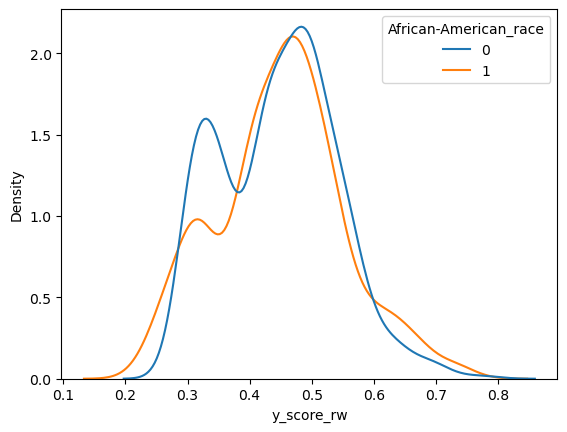

In [33]:
sns.kdeplot(data=test_df, x = 'y_score_rw', hue='African-American_race')

Bias has clearly reduced from the baseline

<B> LFR

In [40]:
# initialise
lfr = LearningFairRepresentation(k=10)

In [41]:
# fit lfr object to training data (remember to standard scale train data)
X_train, y_train, group_a, group_b = train_data
scaler1 = StandardScaler()
X_train_t = scaler1.fit_transform(X_train)
lfr.fit(X_train_t, y_train, group_a, group_b)

Optimization Progress:   0%|          | 0/5000 [00:00<?, ?it/s]

In [36]:
# transform train
X_train, y_train, group_a_train, group_b_train = train_data
X_train_t = scaler1.fit_transform(X_train)
new_X_train = lfr.transform(X_train_t, group_a_train, group_b_train)

# transform test
X_test, y_test, group_a_test, group_b_test = test_data
X_test_t = scaler1.fit_transform(X_test)
new_X_test = lfr.transform(X_test_t, group_a_test, group_b_test)

In [42]:
# Fit a model with new data (transformed by LFR algorithm)

# train
X, y, group_a, group_b = train_data
X = new_X_train
scaler2 = StandardScaler()
Xt = scaler2.fit_transform(X)
model = LogisticRegression()
model.fit(Xt, y)

# test
X, y, group_a, group_b = test_data
X = new_X_test
Xt = scaler2.transform(X)
y_pred = model.predict(Xt)
y_proba = model.predict_proba(Xt)
y_score = y_proba[:,1]
y_true = y

c:\Users\athar\anaconda3\lib\site-packages\sklearn\utils\validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [43]:
# efficacy
metrics_dataframe(y_pred, y_true)

,Value
Metric,
Accuracy,0.609603
Balanced accuracy,0.584077
Precision,0.646302
Recall,0.308282
F1-Score,0.417445


In [44]:
# bias
classification_bias_metrics(group_a, group_b, y_pred, y_true, metric_type='both')

,Value,Reference
Metric,,
Statistical Parity,0.033013,0
Disparate Impact,1.164843,1
Four Fifths Rule,0.858485,1
Cohen D,0.080232,0
2SD Rule,1.519132,0
Equality of Opportunity Difference,0.039760,0
False Positive Rate Difference,-0.009247,0
Average Odds Difference,0.015257,0
Accuracy Difference,-0.043308,0


In [45]:
test_df['y_pred_lfr'] = y_pred
test_df['y_score_lfr'] = y_score

In [46]:
feature_imp_rw = pd.DataFrame({'Varibale' : list(X_train.columns), 'coeff' : list(model.coef_[0])})
feature_imp_rw.sort_values(by='coeff',ascending=False)

,Varibale,coeff
5,priors_count,0.093353
7,time_in_custody_in_days,0.078224
0,sex,0.065322
1,age,0.062695
6,c_charge_desc,0.024096
4,juv_other_count,0.021162
9,African-American_race,0.014718
8,time_in_jail_in_days,0.010639
10,Felony_c_charge_degree,0.003175
3,juv_misd_count,-0.019759


Note : Model coefficients have gotten fairer, but their values have gotten smaller, and estimated for sex and african american race still seem to be strongly positive in comparison to ther variables

<AxesSubplot:xlabel='y_score_lfr', ylabel='Density'>

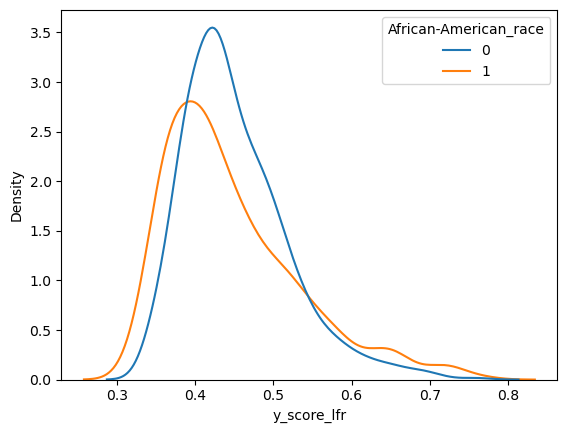

In [47]:
sns.kdeplot(data=test_df, x = 'y_score_lfr', hue='African-American_race')